<a href="https://colab.research.google.com/github/JulioCastillo1/TP1-Datos/blob/master/TP1-Datos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import wordcloud as wc
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

%pylab inline

url='https://raw.githubusercontent.com/JulioCastillo1/TP1-Datos/master/train.csv'
tweets = pd.read_csv(url)
   

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Populating the interactive namespace from numpy and matplotlib


Primera vista a la estructura del dataframe:

In [0]:
tweets.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Observamos los tipos de datos de cada columna:

In [0]:
tweets.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

Grafico el porcentaje de veracidad de tweets según keyword. **¿Qué asuntos están más asociados a desastres reales y cuáles a metafóricos?**

Text(0, 0.5, 'Porcentaje de verdaderos')

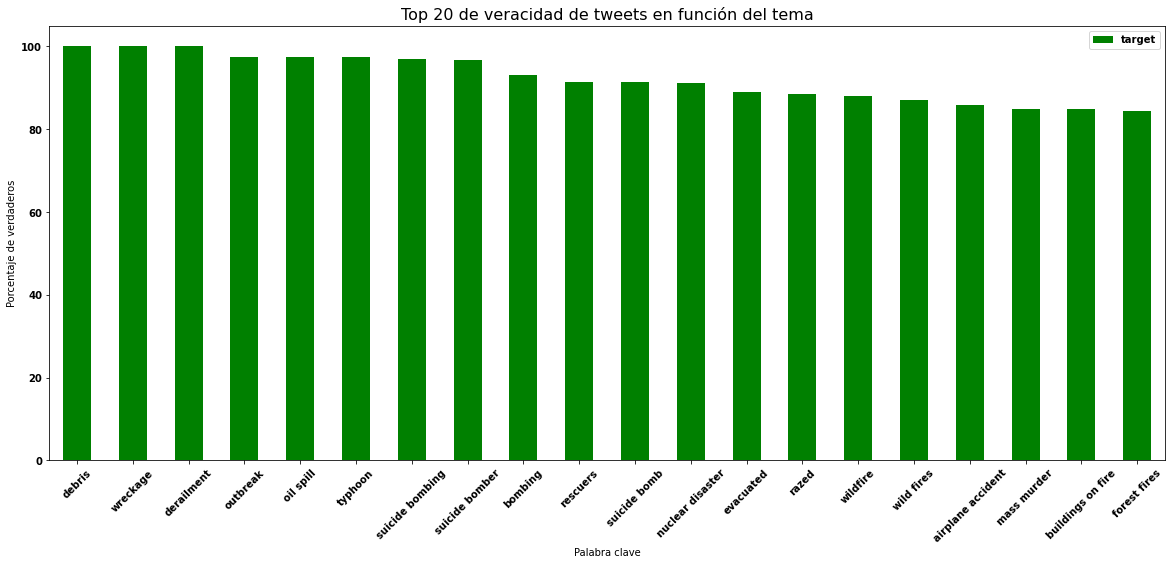

In [0]:
truth_percentage_by_keyword = tweets.groupby('keyword')['target'].agg('mean')\
  .to_frame()\
  .sort_values(by='target', ascending=False)\
  .round({'target': 4})
truth_percentage_by_keyword['target'] = truth_percentage_by_keyword['target'] * 100

# Como las categorías son más de 200, tengo que hacer un gráfico con el top 20 y el bottom 20, algo así, sino no se ve nada
truth_percentage_by_keyword_top20 = truth_percentage_by_keyword[:20]
truth_percentage_by_keyword_top20.index = truth_percentage_by_keyword_top20.index.str.replace('%20', ' ')

truth_percentage_by_keyword_top20.plot(kind='bar', figsize=(20,8), rot=45, color='green');
plt.title('Top 20 de veracidad de tweets en función del tema', fontsize=16)
ax = plt.gca();
ax.set_xlabel('Palabra clave')
ax.set_ylabel('Porcentaje de verdaderos')



Text(0, 0.5, 'Porcentaje de verdaderos')

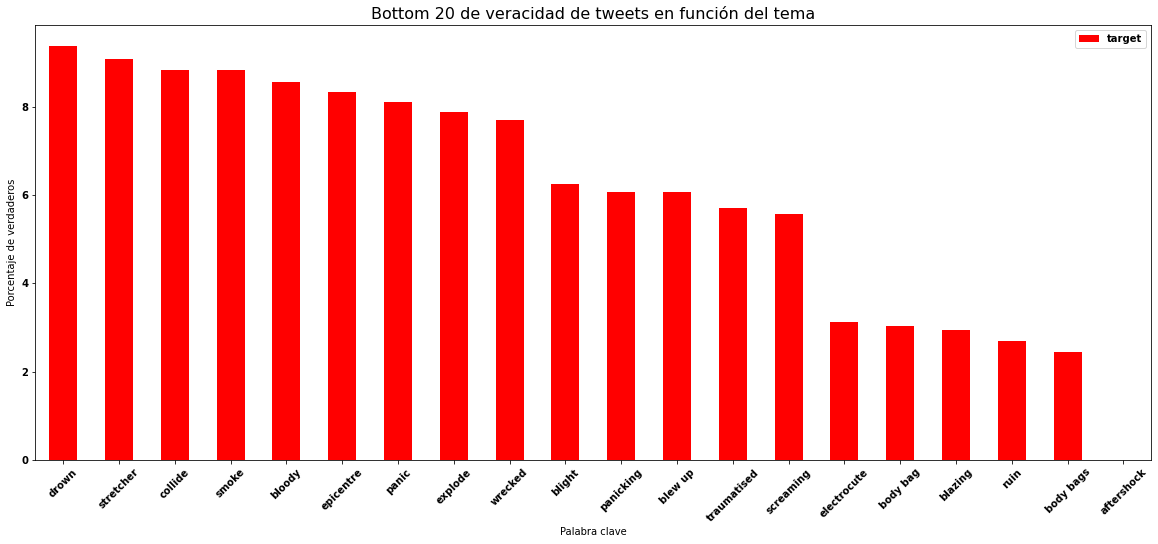

In [0]:
truth_percentage_by_keyword_bottom20 = truth_percentage_by_keyword[-20:] #ídem a .tail(20)
truth_percentage_by_keyword_bottom20.index = truth_percentage_by_keyword_bottom20.index.str.replace('%20', ' ')

truth_percentage_by_keyword_bottom20.plot(kind='bar', figsize=(20,8), rot=45, color='red');
plt.title('Bottom 20 de veracidad de tweets en función del tema', fontsize=16)
ax = plt.gca();
ax.set_xlabel('Palabra clave')
ax.set_ylabel('Porcentaje de verdaderos')


**Conclusiones**

Observando los dos gráficos previos, se puede notar qué tipos de palabras clave suelen ser sobre desastres reales y cuáles se prestan más a la broma, metáfora, chiste u otro hecho artístico.

La lista de veracidad la encabezan palabras clave como debris (escombros), wreckage (destrucción), derailment (descarrilamiento), outbreak (brote), oil spill (derrame de petróleo), razed (arrasado), typhoon (tifón), wildfire (incendio forestal), airplane accidents (no hace falta traducción :)) y buildings on fire (incendios en edificios). 

La de tweets sobre desastres no reales tiene temas como drown (ahogar o empapar), stretcher (camilla), collide (colisionar), bloody (sangrante), panic (pánico), explode (explotar), wrecked (borracho), screaming (gritando), electrocute (electrocución), body bag (bolsa de cadáver), aftershock (que no es usado en el sentido del terremoto físico sino metafórico), blight (plaga de plantas, literal o metafórica). 

Entonces lo que se nota es que cuando las palabras claves están asociadas a desastres en gran escala, donde no se involucra a una persona sino a multitudes, cuando refiere a estructuras complejas, grandes o a un accidente en zona geográfica, estos hablan casi seguro de desastres reales.
En cambio los desastres no reales tienen como palabras claves las de asuntos más personales, individuales, emociones, o sea asuntos de menor escala.
Esa es la tendencia que se divisa.

In [0]:
tweets['longitud'] = tweets['text'].str.len()
tweets_description = tweets['longitud'].describe()
tweets_description = tweets_description.to_frame()
tweets_description.rename(index={'mean':'promedio', 'min':'mínimo', 'max':'máximo'}, inplace=True)
tweets_description.drop(['count', 'std', '25%', '50%', '75%'], inplace=True)
tweets_description['longitud'] = tweets_description['longitud'].astype(int)
tweets_description

,longitud
promedio,101
mínimo,7
máximo,157


In [0]:
bins = pd.cut(tweets['longitud'], bins=[0, 20, 40, 60, 80, 100, 120, 140, 160, 180])
tweets['bin'] = bins
tweets

,id,keyword,location,text,target,longitud,bin
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,"(60, 80]"
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,"(20, 40]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,"(120, 140]"
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,"(60, 80]"
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,"(80, 100]"
...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,83,"(80, 100]"
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,125,"(120, 140]"
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,65,"(60, 80]"
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,137,"(120, 140]"


In [0]:
tweets_percentage = tweets.groupby('bin').agg({'target':'mean'})
tweets_percentage['target'] = round(tweets_percentage['target'] * 100, 2);
tweets_percentage.rename(columns={'target':'porcentaje'}, inplace=True)

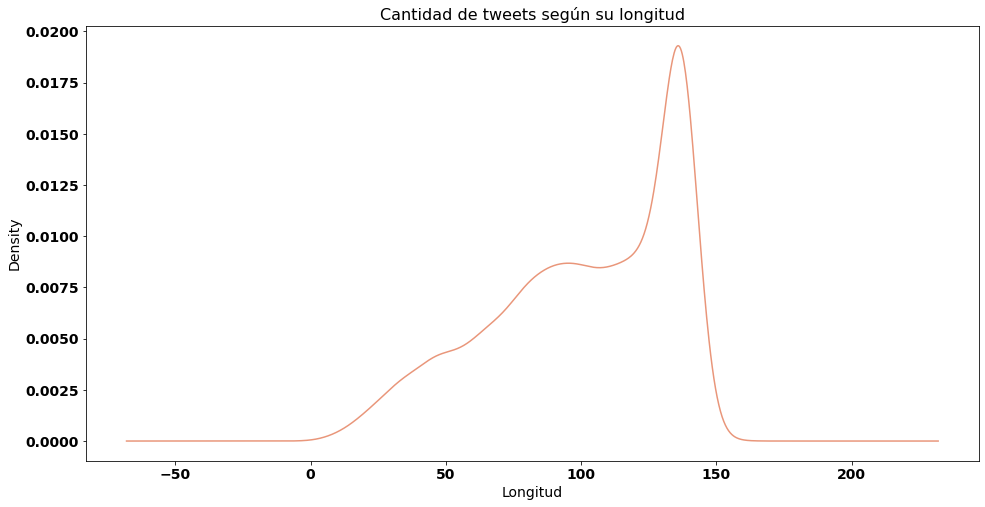

In [0]:
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['font.weight'] = 'bold'

fig = plt.figure()
ax = fig.add_subplot(111)

plt.title('Cantidad de tweets según su longitud', fontsize=16)
ax.set_xlabel('Longitud')
tweets['longitud'].plot.kde(color='darksalmon', figsize=(16, 8))

plt.show()

Text(0, 0.5, 'Cantidad de caracteres')

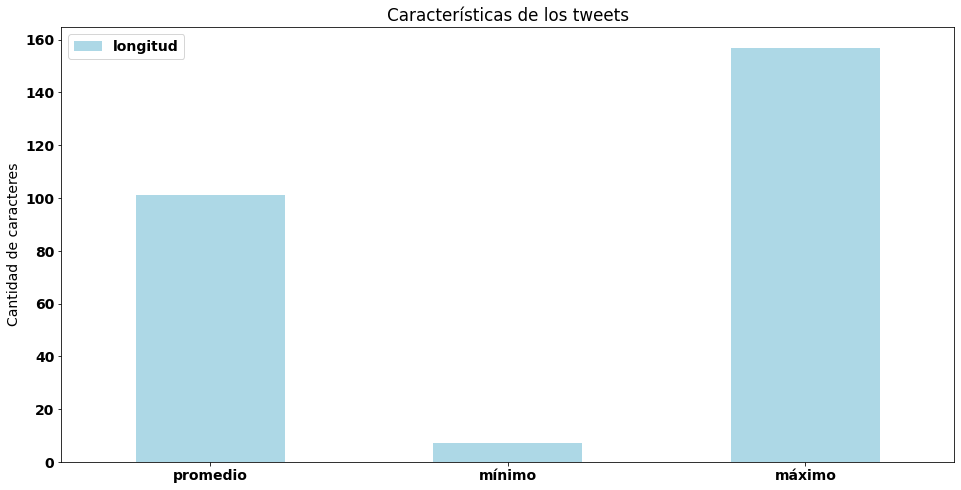

In [0]:
tweets_description.plot(kind='bar', figsize=(16,8), rot=0, title='Características de los tweets', color='lightblue');
ax = plt.gca();
ax.set_ylabel('Cantidad de caracteres')

,porcentaje
bin,
"(0, 20]",8.97
"(20, 40]",18.43
"(40, 60]",26.40
"(60, 80]",36.61
"(80, 100]",48.22
"(100, 120]",45.36
"(120, 140]",49.91
"(140, 160]",46.31
"(160, 180]",NaN


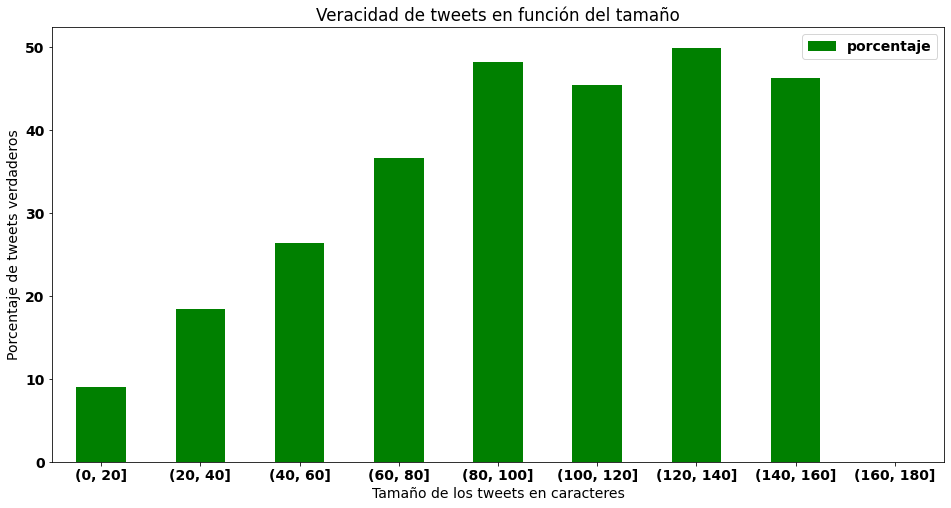

In [0]:
tweets_percentage.plot(kind='bar', figsize=(16,8), rot=0, title='Veracidad de tweets en función del tamaño', color='green');
ax = plt.gca();
ax.set_xlabel('Tamaño de los tweets en caracteres')
ax.set_ylabel('Porcentaje de tweets verdaderos')
tweets_percentage

**Keywords mas frecuentes.**

In [0]:
def getStringFromSeries(series):
    string = ""
    for i in series:
        string = string + " " + i
    return string

In [0]:
strings = getStringFromSeries(tweets['text'])

In [0]:
wordcloud = wc.WordCloud().generate(strings)

(-0.5, 399.5, 199.5, -0.5)

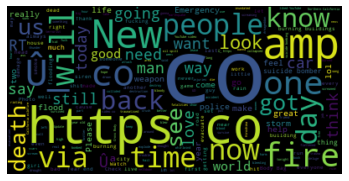

In [0]:
plt.imshow(wordcloud,interpolation = "bilinear")
plt.axis("off")

Puede observarse que muchos de los términos que se muestran como los más frecuentes son irrelevantes, al tratarse stop words, protocolos y dominios de internet, etc. Se procede a realizar una limpieza de dichas palabras.

In [0]:
stopwordsList = stopwords.words('english')

In [0]:
cleaned = ' '.join([word for word in strings.split() if word not in stopwordsList])
cleaned = cleaned.replace("https"," ")
cleaned = cleaned.replace("co"," ")

In [0]:
wordcloud = wc.WordCloud().generate(cleaned)

(-0.5, 399.5, 199.5, -0.5)

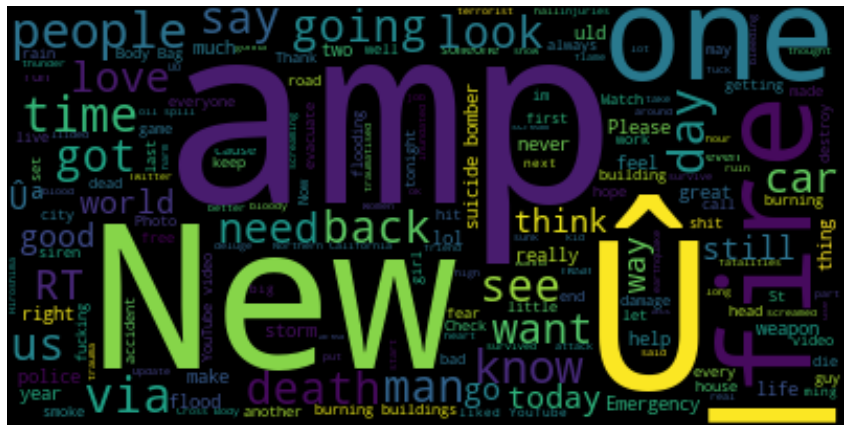

In [0]:
plt.figure(figsize=(15,10))
plt.imshow(wordcloud,interpolation = "bilinear")
plt.axis("off")

A continuación se procede a analizar las keywords mas prevalentes.

In [0]:
keywords=tweets[['keyword']].dropna().astype('str')

In [0]:
getStringFromSeries(keywords['keyword'])

' ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock airplane%20accident airplane%20accident airplane%20accide

In [0]:
wordcloud = wc.WordCloud().generate(getStringFromSeries(keywords['keyword']))

(-0.5, 399.5, 199.5, -0.5)

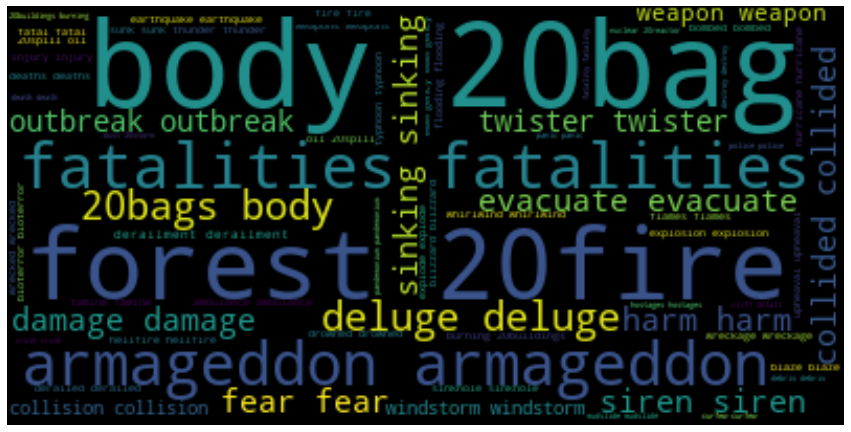

In [0]:
plt.figure(figsize=(15,10))
plt.imshow(wordcloud,interpolation = "bilinear")
plt.axis("off")

De esta manera pueden visualizarse los términos que son mas frecuentes, y que a la vez son relevantes.